**FASE 0 Data preparation and split of the dataset**
For this project I will be using the *ADS-B Message Injection Attacks Dataset* from *Mendeley Data*

1. Import and Upload

In [237]:
import pandas as pd 
from sklearn.model_selection import train_test_split
#upload the dataset
df = pd.read_csv("Dataset ADB-S.csv")
#see if everything seems ok
print("Uploaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
display(df.head())

Uploaded dataset with {df.shape[0]} rows and {df.shape[1]} columns


,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact,rss,doppler,label
0,1627918130,0c20b6,41.073349,-73.930298,194.919295,231.859760,0.0,CMP312,False,False,1364.0,10363.2,10675.62,1627918130,1627918130,-85.607674,588.045536,0
1,1627918140,0c20b6,41.062500,-73.948425,194.833737,231.647341,0.0,CMP312,False,False,1364.0,10363.2,10675.62,1627918140,1627918140,-85.601463,827.517243,0
2,1627918150,0c20b6,41.051393,-73.966952,195.153367,231.528897,0.0,CMP312,False,False,1364.0,10363.2,10675.62,1627918150,1627918150,-85.609035,774.034419,0
3,1627918160,0c20b6,41.040918,-73.984368,195.153367,231.528897,0.0,CMP312,False,False,1364.0,10363.2,10675.62,1627918160,1627918160,-85.631899,790.374778,0
4,1627918170,0c20b6,41.035418,-74.006463,195.237429,251.741020,0.0,CMP312,False,False,1364.0,10363.2,10675.62,1627918169,1627918170,-85.744771,-94.629770,1


2. SPLIT

60% Train, 20% Val, 20% Test
the variable **icao24** represents the "id" of the aircraft.The same icao24 (aircraft) can have multiple registers at different times. Splitting by this variable ensures us that the model is not learning the ids but the behavior. Each aircraft is in just one dataframe.

In [238]:
aircrafts = df['icao24'].unique()
#60% train_ids, 40% rest_ids -> 20% val_ids, 20% test_ids
train_ids, rest_ids = train_test_split(aircrafts, test_size=0.4, random_state=42)
val_ids, test_ids = train_test_split(rest_ids, test_size=0.5, random_state=42)
#create the dataframes
df_train = df[df['icao24'].isin(train_ids)].copy()
df_val = df[df['icao24'].isin(val_ids)].copy()
df_test = df[df['icao24'].isin(test_ids)].copy()

print(f"Number of rows of each dataframe: Train ({len(df_train)}), Val ({len(df_val)}), Test ({len(df_test)})")

Number of rows of each dataframe: Train (13778), Val (4334), Test (4204)


3. Order the train dataframe by time. 
We only order this dataframe because is the one we are working with, the other two will be only used for testing.
Ordering each aircraft by time let us have its real trayectory step by step.

In [239]:
df_train = df_train.sort_values(by=['icao24', 'time']).reset_index(drop=True)
#reorder and crate a new index

## **FASE 1 Studing the variables** 

import the packages and libraries

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

## classes distribution
- Label 0: NORMAL - Real aircraft traffic following physical laws.
-  Label 1: GHOSTING - Injection of a non-existent aircraft with static or linear flight parameters.
-  Label 2: TRAJECTORY MODIFICATION - Hijacking a real signal to report false coordinates (drifting).
-  Label 3: FLOODING - Denial of Service (DoS) attack; massive message injection to saturate the receiver.

In [241]:
print("\nClasees distribution:")
print("\nNumber of cases of each class")
print(df_train['label'].value_counts())
print("\nPercentage of each class")
print(df_train['label'].value_counts(normalize=True) * 100)


Clasees distribution:

Number of cases of each class
label
0    6722
2    3977
1    1544
3    1535
Name: count, dtype: int64

Percentage of each class
label
0    48.787923
2    28.864857
1    11.206271
3    11.140949
Name: proportion, dtype: float64


## Airplane balance

here we see for each aircraft how many times has been registed with the different labels. For example, an aircraft that had real trayectories but was hacked will have both, labels 0 and 1,2 or 3. *Take into accont that even though we are doing the training looking for the same aircraft over time, the final detection (the objetive) will be of each message.*

In [242]:
aircraft_label = pd.crosstab(df_train['icao24'], df_train['label'])
display(aircraft_label.head(20)) #Only print the 20 first rows to see how it works


label,0,1,2,3
icao24,,,,
0c20b6,4,13,0,5
20102c,0,0,267,0
3ec212,0,0,60,0
4079eb,1,7,0,5
43c7d8,0,0,267,0
48497b,0,0,267,0
4ba94f,26,82,0,29
7103d8,16,36,0,8
71c359,24,67,0,21


## Average trayectory duration

Calculate for each aircraft and label what is the duration (in seconds) of the trayectory.
Then, for each label calculate the average duration.


In [243]:
df = df_train.sort_values(['icao24', 'time'])

df['new_flight'] = (
    (df['onground'].shift(1) == True) & (df['onground'] == False)
) | (
    df['time'].diff() > 600  #10 min because messages are sent each 0.5 / 1 sec
) | (
    df['icao24'] != df['icao24'].shift(1)
)

df['flight_id'] = df.groupby('icao24')['new_flight'].cumsum()

durations = df.groupby(['icao24', 'flight_id', 'label'])['time'].agg(lambda x: x.max() - x.min())
avg_duration = durations.groupby('label').mean()
print(avg_duration)


label
0     453.902439
1     371.428571
2    2658.125000
3     322.666667
Name: time, dtype: float64


## Descriptive statistics

Study of the velocity and baroaltitude of each label

In [244]:
stats = df_train.groupby('label')[['velocity', 'baroaltitude']].describe().T
display(stats)

label                          0             1            2             3
velocity     count   5193.000000   1377.000000  3977.000000   1340.000000
             mean      91.132773     93.353719   148.960635    142.450560
             std       61.618453     66.862356    86.994315     76.616286
             min        0.000000      1.626815     1.002808      0.000000
             25%       48.622443     48.374152    72.878713     82.830277
             50%       70.582017     68.469385   148.092640    138.181612
             75%      131.643395    130.190928   224.700553    201.786677
             max      311.837095    287.447167   299.955020    299.616708
baroaltitude count   5171.000000   1300.000000  3977.000000   1303.000000
             mean    1617.816921   1748.584846   282.877699   1773.629563
             std     2594.097251   2774.938821  1883.382259   2944.008146
             min      -60.960000    -15.240000 -2950.733065    -22.860000
             25%      129.540000    121.920000 -1432.839435     60.960000
             50%      487.680000    601.980000   -38.392715    320.040000
             75%     1668.780000   1813.560000  1990.382354   1581.150000
             max    14074.140000  11155.680000  3647.561152  11285.220000

## Data interpretation

Label 0 — NORMAL
- *Speed:* Avg 91 m/s, moderate std. Includes takeoff, cruise and landing. Normal range of speeds
- *Baroaltitude:* Realistic altitudes from ground level to cruise. Normal
- *Summary*: Normal aircraft behavior

Label 1 — GHOSTING
- *Speed:* Similar to label 0 (normal)
- *Baroaltitude:* Similar to label 0 (normal)
- *Summary :* Normal aircraft behavior, good imitaiton

Label 2 — TRAJECTORY MODIFICATION
- *Speed:* Avg 149 m/s (real aircraft velocities for cruise phase). The attacker *doesn't modify the speed*
- *Baroaltitude:* Contains impossible values, the attacker manipulates position/altitude, causing unrealistic values
- *Summary :* Speed normal for cruise phase but altitude becomes extrange

Label 3 — FLOODING
- *Speed:* Avg 142 m/s with high std (variability), that's because there is a mix of real aircraft data and injected noise
- *Baroaltitude:* Very noisy and inconsistent due to random and/or duplicated messages
- *Summary :* chaotic and inconsistent values beacuse the objetive is to overhelm the system




## Null values

use this information later, to see if we should drop some characteristics

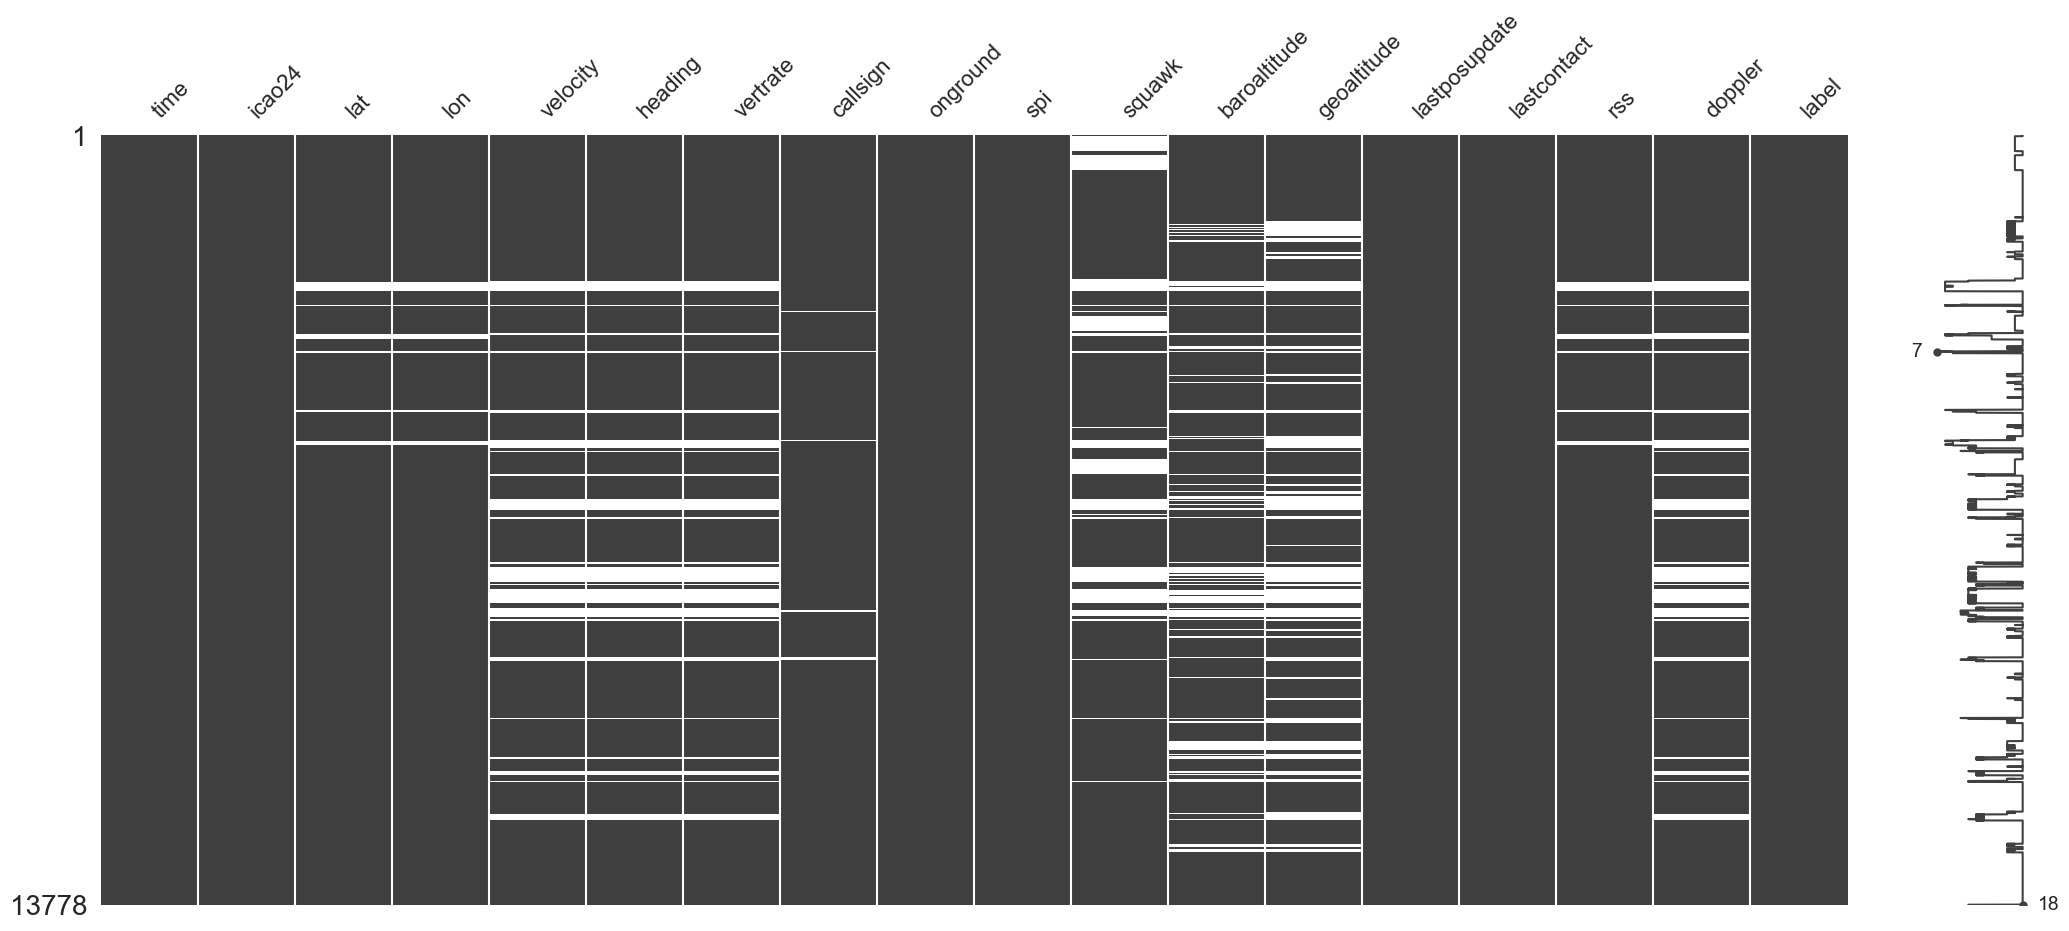

,nulls,percent
time,0,0.000000
icao24,0,0.000000
lat,435,3.157207
lon,435,3.157207
velocity,1891,13.724779
heading,1891,13.724779
vertrate,1891,13.724779
callsign,139,1.008855
onground,0,0.000000
spi,0,0.000000


In [245]:
msno.matrix(df_train)
plt.show()
def nulls(df):
    nulls = df.isnull().sum()
    perc = (nulls / len(df)) * 100
    return pd.DataFrame({'nulls': nulls, 'percent': perc})
nulls(df_train)



In [246]:

# B. Comprobación de Correlación Sospechosa (Data Leakage)
# ¿El valor de 'spi' cambia solo cuando hay un ataque?
if 'spi' in df_train.columns:
    print("\n¿Es 'spi' un delator del ataque?")
    print(pd.crosstab(df_train['spi'], df_train['label']))
if 'callsign' in df_train.columns:
    print("\n¿Es 'callsign' un delator del ataque?")
    print(pd.crosstab(df_train['callsign'], df_train['label']))


¿Es 'spi' un delator del ataque?
label     0     1     2     3
spi                          
False  6721  1544  3977  1535
True      1     0     0     0

¿Es 'callsign' un delator del ataque?
label      0   1  2   3
callsign               
AAL1297   83   0  0   0
AAL2036   39   0  0   0
AAL2124   30   0  0   0
AAL2146   20   0  0   0
AAL2275   19   0  0   0
...       ..  .. ..  ..
UAL660    81   0  0   0
UCA4875    2  23  0  14
UCA4995    5  10  0   2
VET430    60   0  0   0
VTE209     3  72  0  45

[166 rows x 4 columns]


In [247]:

cols_to_drop = ['spi']

df_train = df_train.drop(columns=cols_to_drop)
df_val = df_val.drop(columns=cols_to_drop)
df_test = df_test.drop(columns=cols_to_drop)
print(f"Limpieza completada. Columnas restantes: {df_train.columns.tolist()}")

Limpieza completada. Columnas restantes: ['time', 'icao24', 'lat', 'lon', 'velocity', 'heading', 'vertrate', 'callsign', 'onground', 'squawk', 'baroaltitude', 'geoaltitude', 'lastposupdate', 'lastcontact', 'rss', 'doppler', 'label']


## **FASE 2 Univariate analysis** 

# Density histograms for seed and altitude

Helps to identify anomalies

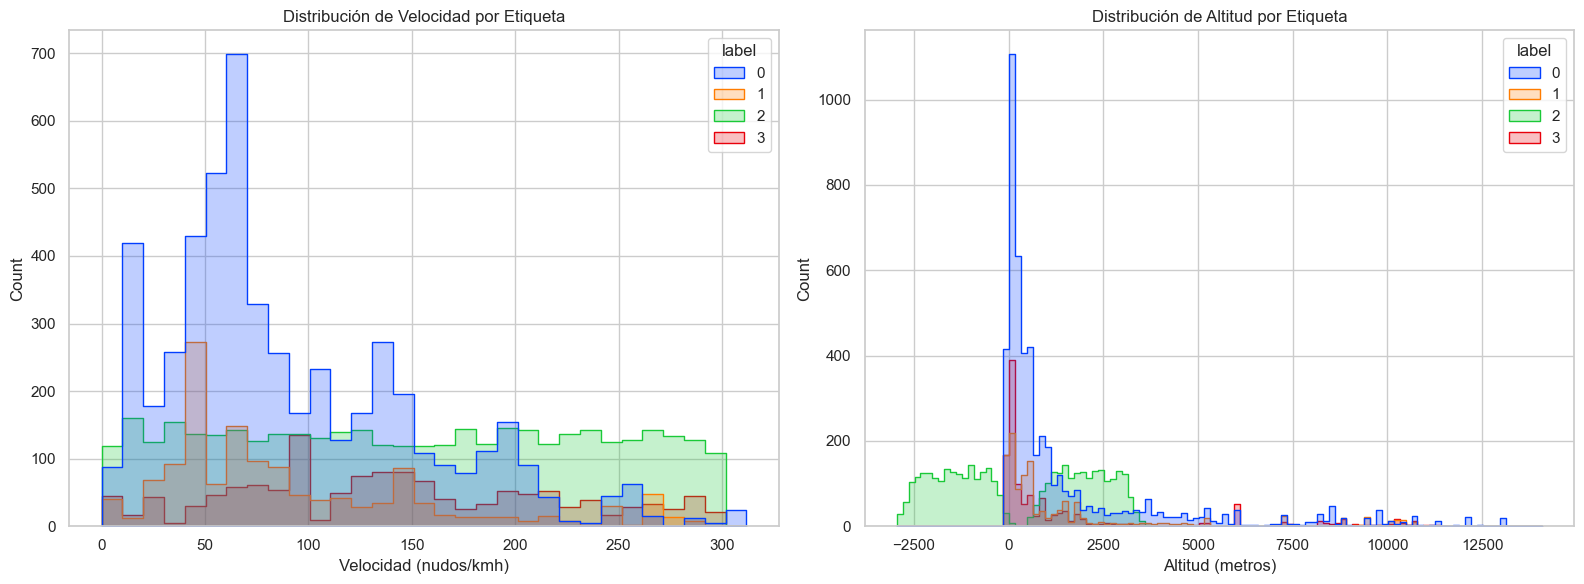

In [248]:


# Configuramos el estilo visual
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 6))

# Subplot 1: Velocidad
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='velocity', hue='label', element='step', palette='bright', common_norm=False)
plt.title('Distribución de Velocidad por Etiqueta')
plt.xlabel('Velocidad (nudos/kmh)')

# Subplot 2: Altitud Barométrica
plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='baroaltitude', hue='label', element='step', palette='bright', common_norm=False)
plt.title('Distribución de Altitud por Etiqueta')
plt.xlabel('Altitud (metros)')

plt.tight_layout()
plt.show()

# Boxplots

C:\Users\sofia\AppData\Local\Temp\ipykernel_26272\3730999913.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x='label', y='velocity', palette='bright')
C:\Users\sofia\AppData\Local\Temp\ipykernel_26272\3730999913.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x='label', y='baroaltitude', palette='bright')
C:\Users\sofia\AppData\Local\Temp\ipykernel_26272\3730999913.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x='label', y='vertrate', palette='bright')


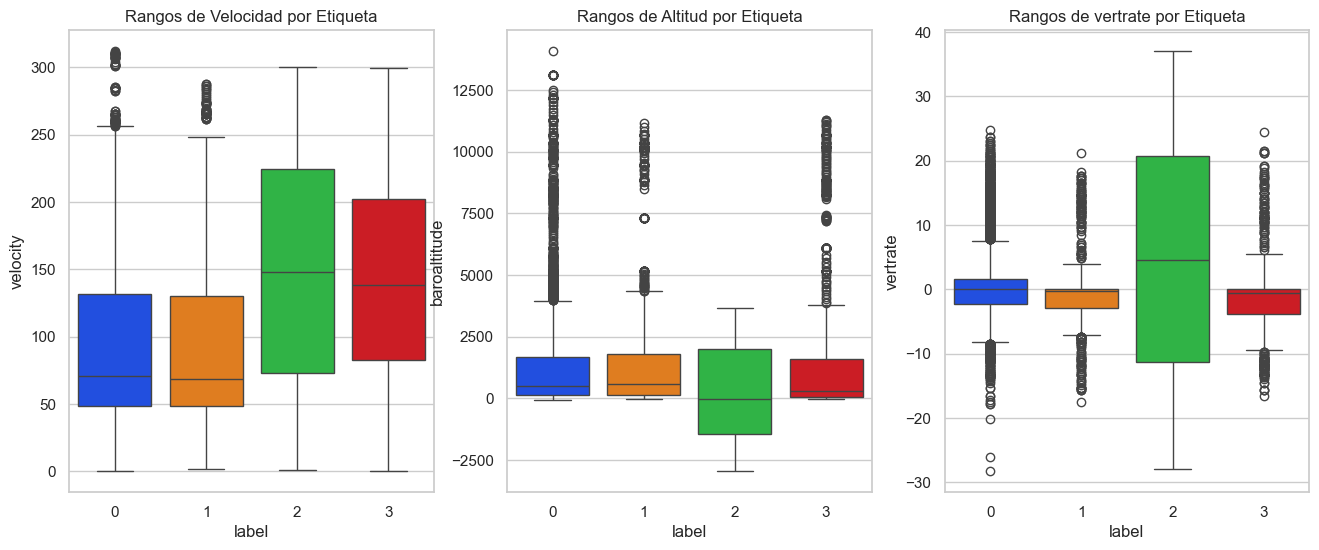

In [258]:
plt.figure(figsize=(16, 6))

# Subplot 1: Boxplot de Velocidad
plt.subplot(1, 3, 1)
sns.boxplot(data=df_train, x='label', y='velocity', palette='bright')
plt.title('Rangos de Velocidad por Etiqueta')

# Subplot 2: Boxplot de Altitud
plt.subplot(1, 3, 2)
sns.boxplot(data=df_train, x='label', y='baroaltitude', palette='bright')
plt.title('Rangos de Altitud por Etiqueta')

plt.subplot(1, 3, 3)
sns.boxplot(data=df_train, x='label', y='vertrate', palette='bright')
plt.title('Rangos de vertrate por Etiqueta')

plt.show()

speed 
- 0 y 1 normal
- 2 en crucero normalmente
- 3 mucha dispersión
altitude
-  2 imposible values (manipulada)